# Глубокое обучение, ВМК МГУ

## Практическое задание 1.

#### Фамилия, имя: Демьянов Иван

Название: Анализ активаций-2

Датасет: ST Food-101 (нужно научиться подавать на вход сети)

Тип сети: CNN, конкретные обученные сети

Что зависит / что сделать: Анализ активаций (не распределений), входы максимизирующие активации (из выборки)

От чего / как: Перебрать архитектуры, слои, аугментации

Постановка задачи: в данной работе предполагается анализ активаций различных архитекур: рассматриваются визуализации слоев сверточных сетей после применения ReLU, проводится отбор изображений, на которых достигается максимум после активации с последующей их визуализацией. Аналогичные эксперименты будут проведены и с аугментацией.

### Подключение библиотек, загрузка данных 

In [1]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar xzvf food-101.tar.gz

Выходные данные были обрезаны до нескольких последних строк (5000).
food-101/images/cannoli/695879.jpg
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-10

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T, models

from tqdm.notebook import tqdm

## Немного о данных

Датасет ST Food-101 представляет собой набор фото из 101 класса различных блюд: по 750 фото каждого классса для тренировки и 250 для валидации.

In [3]:
train_imgs = []
test_imgs = []
class_to_idx = {}
idx_to_class = {}

with open("./food-101/meta/classes.txt", 'r') as classes_f:
    for idx, line in enumerate(classes_f.readlines()):
        class_to_idx[line[:-1]] = idx
        idx_to_class[idx] = line[:-1]
        
with open("./food-101/meta/train.txt", 'r') as train_f:
    for line in train_f.readlines():
        train_imgs.append(line[:-1])
        
with open("./food-101/meta/test.txt", 'r') as test_f:
    for line in test_f.readlines():
        test_imgs.append(line[:-1])

Ниже приведен объект из датасета.

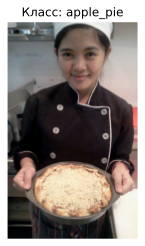

In [4]:
img = Image.open("./food-101/images/" + train_imgs[5] + '.jpg')
plt.imshow(np.array(img))
plt.title('Класс: ' + train_imgs[5][:train_imgs[5].find('/')])
plt.axis('off')
plt.show()

## Обработка данных

In [5]:
transform_train = T.Compose([
    T.Resize([224, 224]),
    T.ToTensor(), 
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

transform_test = T.Compose([
    T.Resize([224, 224]),
    T.ToTensor(), 
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [6]:
train_dataset = datasets.Food101(root='.', split='train', transform=transform_train)
test_dataset = datasets.Food101(root='.', split='test', transform=transform_test)

train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_data_loader = DataLoader(test_dataset, batch_size=32, num_workers=0)

## Обучение сетей

В качестве моделей были выбраны следующие предобученные сети:

* vgg13

* resnet18

Добавим к ним линейный слой с выходом, равным количеству классов и обучим сети. Учитывая, что у нашего датасета довольно много классов и вцелом много данных, применим для обучения сетей transfer learning. Подробнее здесь: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [ ]:
net1 = models.vgg13(pretrained=True)
#for parameter in net1.parameters():
#    parameter.requires_grad = False
net1.classifier[6] = nn.Linear(in_features=4096, out_features=101)

Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth


  0%|          | 0.00/508M [00:00<?, ?B/s]

In [21]:
net2 = models.resnet18(pretrained=True)
#for parameter in net2.parameters():
#    parameter.requires_grad = False
net2.fc = nn.Linear(in_features=512, out_features=101)

In [ ]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net1 = net1.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(
                    net1.parameters(), 
                    lr=0.001) 
exp_lr_scheduler = StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

In [22]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net2 = net2.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(
                    net2.parameters(), 
                    lr=0.001) 
exp_lr_scheduler = StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

In [ ]:
num_epochs=1

net1.to(device)
for epoch in range(num_epochs):

    net1.train()
    running_loss = 0.0
    running_corrects = 0
    count = 0
    
    for inputs, labels in tqdm(train_data_loader):
        count += 1
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net1(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    exp_lr_scheduler.step()
    
    train_epoch_loss = running_loss / len(train_data_loader)
    train_epoch_acc = running_corrects / len(train_data_loader)

    net1.eval()
    running_loss = 0.0
    running_corrects = 0
    

    for inputs, labels in test_data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net1(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    epoch_loss = running_loss / len(test_data_loader)
    epoch_acc = running_corrects.double() / len(test_data_loader)
    
    print("Train: Loss: {:.4f} "
          " Val: Loss: {:.4f}".format(train_epoch_loss, epoch_loss))
    net1.to(device)
net1.eval()

  0%|          | 0/2368 [00:00<?, ?it/s]

Train: Loss: 0.0911  Val: Loss: 0.0600


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

In [23]:
num_epochs=1

net2.to(device)
for epoch in range(num_epochs):

    net2.train()
    running_loss = 0.0
    running_corrects = 0
    count = 0
    
    for inputs, labels in tqdm(train_data_loader):
        count += 1
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net2(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    exp_lr_scheduler.step()
    
    train_epoch_loss = running_loss / len(train_data_loader)
    train_epoch_acc = running_corrects / len(train_data_loader)

    net2.eval()
    running_loss = 0.0
    running_corrects = 0
    

    for inputs, labels in test_data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net2(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    epoch_loss = running_loss / len(test_data_loader)
    epoch_acc = running_corrects.double() / len(test_data_loader)
    
    print("Train: Loss: {:.4f} "
          " Val: Loss: {:.4f}".format(train_epoch_loss, epoch_loss))
    net2.to(device)
net2.eval()

  0%|          | 0/2368 [00:00<?, ?it/s]

Train: Loss: 0.0818  Val: Loss: 0.0598


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Анализ активаций

Рассмотрим как активации преобразовывают данные при прямом проходе по сетям. Здесь осуществляется проверка гипотезы, что на первых слоях в визуализациях проступают контуры изображения, на последних - этого эффекта не наблюдается и активации становятся более локализованные и разреженные.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []

save_output = SaveOutput()

hook_handles = []

for layer in net1.modules():
    if isinstance(layer, torch.nn.modules.ReLU):
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)
out = net1(next(iter(test_data_loader))[0][0].unsqueeze(0).to(device))

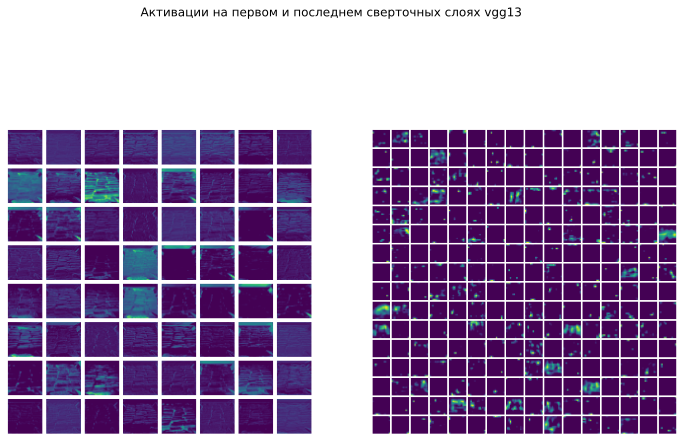

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

relu1 = save_output.outputs[0][0]
relu1 = relu1.squeeze().detach().cpu().numpy()

relu2 = save_output.outputs[9][0]
relu2 = relu2.squeeze().detach().cpu().numpy()
fig = plt.figure(figsize=(12, 8))
plt.suptitle('Активации на первом и последнем сверточных слоях vgg13')
grid1 = ImageGrid(fig, 121, 
                 nrows_ncols=(8, 8),
                 axes_pad=0.05,
                 )

grid2 = ImageGrid(fig, 122, 
                 nrows_ncols=(16, 16),
                 axes_pad=0.02,
                 )

for ax, im in zip(grid1, relu1):
    ax.imshow(im)
    ax.axis('off')
    
for ax, im in zip(grid2, relu2):
    ax.imshow(im)
    ax.axis('off')
plt.axis('off')
plt.show()

По визуализации можно сказать, что гипотеза подтверждается.

Далее проведем аналогичный эксперимент с аугментацией.

In [ ]:
import random

if random.randint(0, 1):
    size = random.randint(100, 240), random.randint(100, 240)
else:
    size = random.randint(100, 240)
transforms=T.Compose([T.RandomHorizontalFlip(p=0.8), T.CenterCrop(size), T.RandomVerticalFlip(p=0.8)])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []

save_output = SaveOutput()

hook_handles = []

for layer in net1.modules():
    if isinstance(layer, torch.nn.modules.ReLU):
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)
out = net1(transforms(next(iter(test_data_loader))[0][0].unsqueeze(0).to(device)))

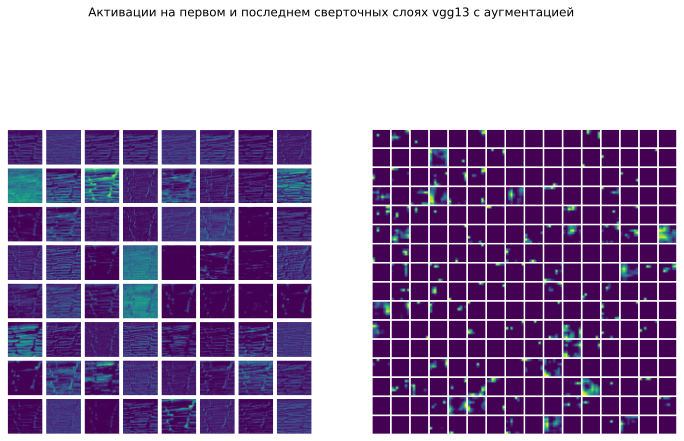

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

relu1 = save_output.outputs[0][0]
relu1 = relu1.squeeze().detach().cpu().numpy()

relu2 = save_output.outputs[9][0]
relu2 = relu2.squeeze().detach().cpu().numpy()
fig = plt.figure(figsize=(12, 8))
plt.suptitle('Активации на первом и последнем сверточных слоях vgg13 с аугментацией')
grid1 = ImageGrid(fig, 121, 
                 nrows_ncols=(8, 8),
                 axes_pad=0.05,
                 )

grid2 = ImageGrid(fig, 122, 
                 nrows_ncols=(16, 16),
                 axes_pad=0.02,
                 )

for ax, im in zip(grid1, relu1):
    ax.imshow(im)
    ax.axis('off')
    
for ax, im in zip(grid2, relu2):
    ax.imshow(im)
    ax.axis('off')
plt.axis('off')
plt.show()

Как видим, гипотеза пожтверждена и на аугментации.

### Аналогичные эксперменты для resnet18

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

net2.to(device)

class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []

save_output = SaveOutput()

hook_handles = []

for layer in net2.modules():
    if isinstance(layer, torch.nn.modules.ReLU):
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)
out = net2(next(iter(test_data_loader))[0][0].unsqueeze(0).to(device))

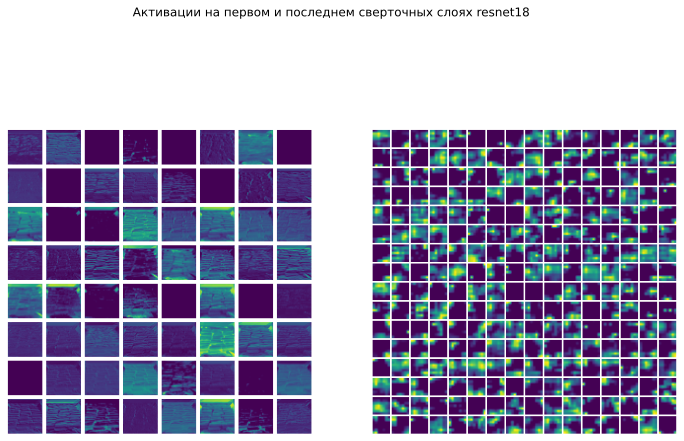

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

relu1 = save_output.outputs[0][0]
relu1 = relu1.squeeze().detach().cpu().numpy()

relu2 = save_output.outputs[16][0]
relu2 = relu2.squeeze().detach().cpu().numpy()
fig = plt.figure(figsize=(12, 8))
plt.suptitle('Активации на первом и последнем сверточных слоях resnet18')
grid1 = ImageGrid(fig, 121, 
                 nrows_ncols=(8, 8),
                 axes_pad=0.05,
                 )

grid2 = ImageGrid(fig, 122, 
                 nrows_ncols=(16, 16),
                 axes_pad=0.02,
                 )

for ax, im in zip(grid1, relu1):
    ax.imshow(im)
    ax.axis('off')
    
for ax, im in zip(grid2, relu2):
    ax.imshow(im)
    ax.axis('off')
plt.axis('off')
plt.show()

По данной визуализации можно сделать вывод, что архитектура resnet18 делает активации менее разреженными, чем vgg13. Гипотеза вновь подтверждается данным примером.

In [ ]:
import random

if random.randint(0, 1):
    size = random.randint(100, 240), random.randint(100, 240)
else:
    size = random.randint(100, 240)
transforms=T.Compose([T.RandomHorizontalFlip(p=0.8), T.CenterCrop(size), T.RandomVerticalFlip(p=0.8)])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []

save_output = SaveOutput()

hook_handles = []

for layer in net2.modules():
    if isinstance(layer, torch.nn.modules.ReLU):
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)
out = net2(transforms(next(iter(test_data_loader))[0][0].unsqueeze(0).to(device)))

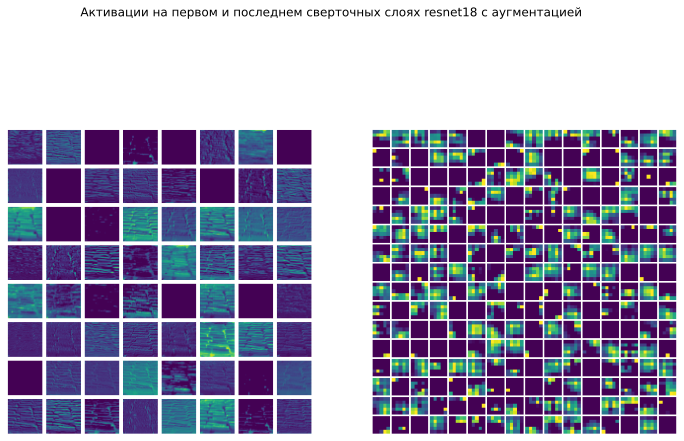

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

relu1 = save_output.outputs[0][0]
relu1 = relu1.squeeze().detach().cpu().numpy()

relu2 = save_output.outputs[16][0]
relu2 = relu2.squeeze().detach().cpu().numpy()
fig = plt.figure(figsize=(12, 8))
plt.suptitle('Активации на первом и последнем сверточных слоях resnet18 с аугментацией')
grid1 = ImageGrid(fig, 121, 
                 nrows_ncols=(8, 8),
                 axes_pad=0.05,
                 )

grid2 = ImageGrid(fig, 122, 
                 nrows_ncols=(16, 16),
                 axes_pad=0.02,
                 )

for ax, im in zip(grid1, relu1):
    ax.imshow(im)
    ax.axis('off')
    
for ax, im in zip(grid2, relu2):
    ax.imshow(im)
    ax.axis('off')
plt.axis('off')
plt.show()

Эксперимент с активацией также подтверждает предположение.

*Как итог,* имеем подтвержденную гипотезу.

## Входы максимизирующие активации (из выборки)

Найдем изображения, которые максимизиурют активации. Для этого выбирается определенный слой и каналы, по которым производится отбор изображений. Под отбором понимается поиск изображений с наибольшой суммой элементов на определенном канале.

In [ ]:
class get_max_input():
    def __init__(self, model, name_layer=None, idxs=None, top_k=1):
        self.model = model
        self.name_layer = name_layer
        self.top_k = top_k
        self.idxs = idxs
        self.im_max_ch = {i:[] for i in idxs}
        self.model.eval()
        self.register_hooks()

    def register_hooks(self):

        def forward_hook_fn(module, input, output):
            self.max_ch = torch.sum(output.squeeze(), dim=(-2,-1))

        modules = list(self.model.features.named_children())

        for name, module in modules:
            if name == self.name_layer:
                self.hook = module.register_forward_hook(forward_hook_fn)

    def forward(self, image, cl):
        with torch.no_grad():
            model_output = self.model(image.unsqueeze(0).to(device))
            for i in self.idxs:
                self.im_max_ch[i].append([self.max_ch[i], image, cl])
                self.im_max_ch[i] = sorted(self.im_max_ch[i], key=lambda val: val[0], reverse=True)[:self.top_k]

In [ ]:
name_layer = '23'
idx_lst = [10, 50, 100]
gm = get_max_input(net1, name_layer, idx_lst, 3)

for data, target in tqdm(test_data_loader):
    for d, t in zip(data, target):
        if torch.cuda.is_available():
            gm.forward(d.to(device), t.to(device).item())
gm.hook.remove()

  0%|          | 0/790 [00:00<?, ?it/s]

После нахождения входов, максимизирующих активации, визуализируем их при помощи Guided Backpropagation. Подробнее об этом можно посмотерть здесь - https://www.coderskitchen.com/guided-backpropagation-with-pytorch-and-tensorflow/

In [17]:
def get_im_grad(model, ch_num, top_img_num, t=None):
    
    if t is None:
        im = gm2.im_max_ch[ch_num][top_img_num][1]
    else:
        im = t(gm2.im_max_ch[ch_num][top_img_num][1])
    
    def relu_hook_function(module, grad_in, grad_out):
        if isinstance(module, torch.nn.ReLU):
            return (torch.clamp(grad_in[0], min=0.),)
    
    for i, module in enumerate(model.modules()):
        if isinstance(model, torch.nn.ReLU):
            module.register_backward_hook(relu_hook_function)
    
    im.requires_grad = True
    # forward/inference
    out = model(im.unsqueeze(0).to(device))
    # backprop
    out[0, gm2.im_max_ch[ch_num][top_img_num][2]].backward()
    grads = im.grad

    return im, grads

In [12]:
import torchvision

def plot_maps(img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(15,45))
    plt.subplot(1,3,1)
    plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="gray")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(img2, cmap = "gray")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(img1*mix_val+img2/mix_val, cmap = "gray" )
    plt.axis("off")


def norm_flat_image(img):
    grads_norm = prep_output(img)
    grads_norm = grads_norm[:,:,0]+ grads_norm[:,:,1]+ grads_norm[:,:,2]

    grads_norm = (grads_norm - np.min(grads_norm))/ (np.max(grads_norm)- np.min(grads_norm))
    return grads_norm

def prep_output(img_tensor):

    out = img_tensor[0]
    out = out.detach().to('cpu').numpy().transpose(1, 2, 0)
    return out

Визуализируем результаты: 

* слева - визуализация градинета

* по центру - полутоновое изображение исходного датасета

* справа - наложение с коэффициентами вышеперечисленных изображений.

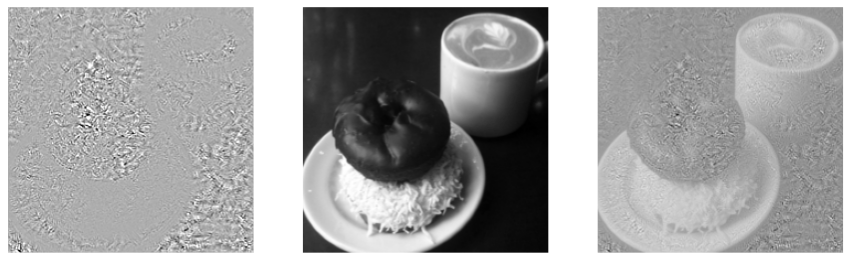

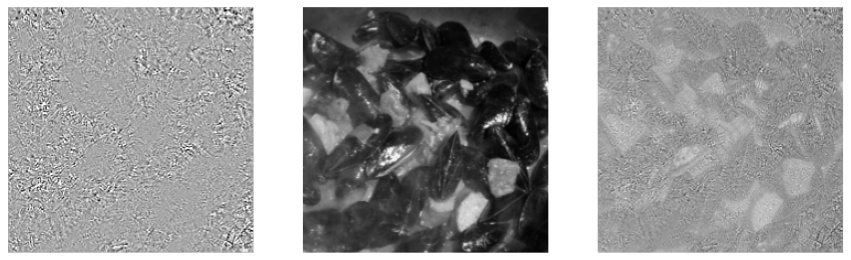

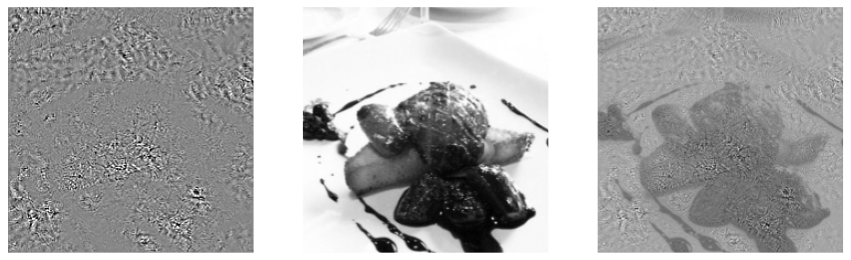

In [ ]:
#filter10
for i in range(3):
    img, grad = get_im_grad(net1, 10, i)
    plot_maps(norm_flat_image(grad.unsqueeze(0)), norm_flat_image(img.unsqueeze(0)))

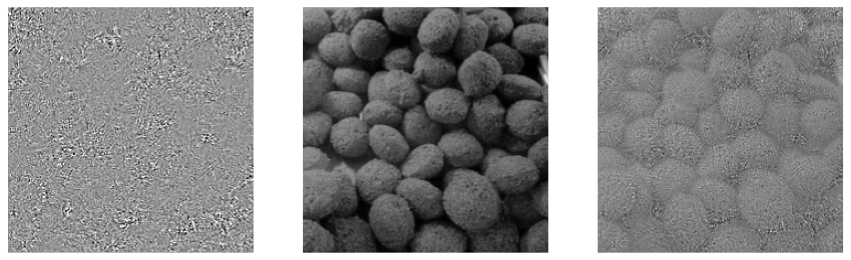

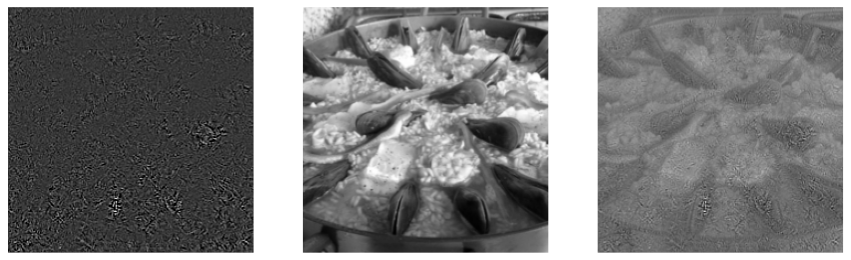

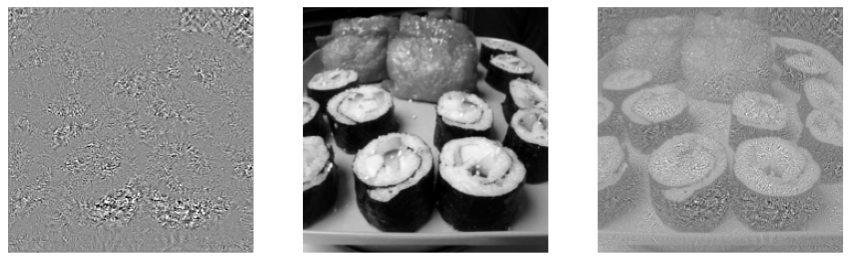

In [ ]:
#filter50
for i in range(3):
    img, grad = get_im_grad(net1, 50, i)
    plot_maps(norm_flat_image(grad.unsqueeze(0)), norm_flat_image(img.unsqueeze(0)))

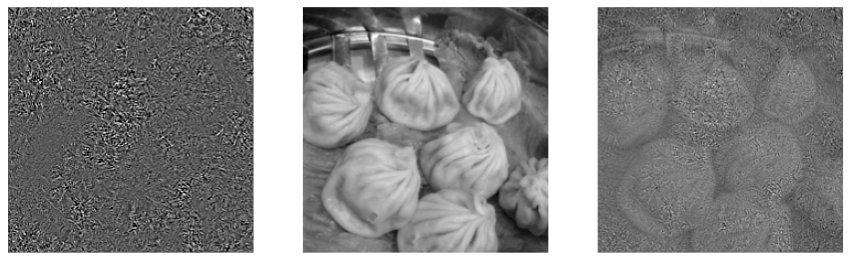

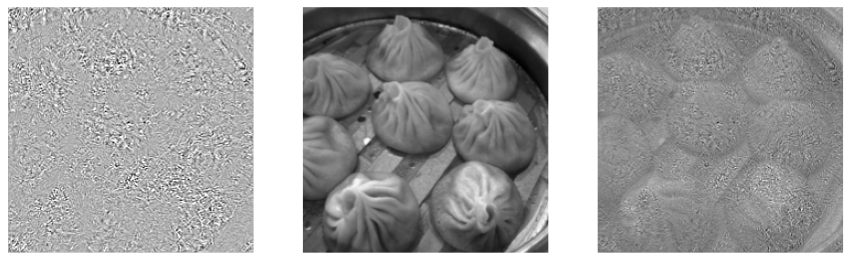

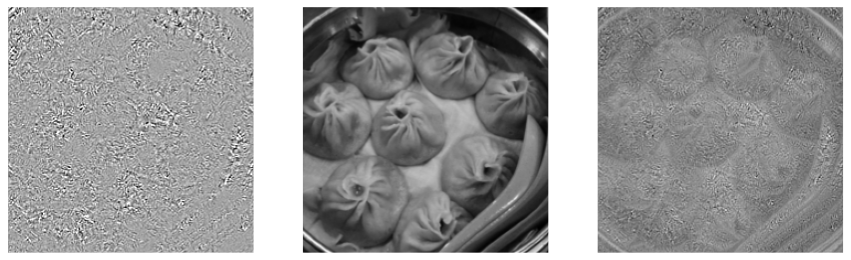

In [ ]:
#filter100
for i in range(3):
    img, grad = get_im_grad(net1, 100, i)
    plot_maps(norm_flat_image(grad.unsqueeze(0)), norm_flat_image(img.unsqueeze(0)))

### Аналогичные эксперменты для resnet18

In [24]:
class get_max_input2():
    def __init__(self, model, relu_num, idxs=None, top_k=1):
        self.model = model
        self.relu_num = relu_num
        self.top_k = top_k
        self.idxs = idxs
        self.im_max_ch = {i:[] for i in idxs}
        self.model.eval()
        self.register_hooks()

    def register_hooks(self):

        def forward_hook_fn(module, input, output):
            self.max_ch = torch.sum(output.squeeze(), dim=(-2,-1))
        
        i = 0
        for layer in self.model.modules():
            if isinstance(layer, torch.nn.modules.ReLU):
                i += 1
                if i == self.relu_num:
                    self.hook = layer.register_forward_hook(forward_hook_fn)

    def forward(self, image, cl):
        with torch.no_grad():
            model_output = self.model(image.unsqueeze(0).to(device))
            for i in self.idxs:
                self.im_max_ch[i].append([self.max_ch[i], image, cl])
                self.im_max_ch[i] = sorted(self.im_max_ch[i], key=lambda val: val[0], reverse=True)[:self.top_k]

In [10]:
idx_lst = [10, 50, 100]
net2 = net2.to(device)
gm2 = get_max_input2(net2, 9, idx_lst, 3)
torch.cuda.memory_summary(device=None, abbreviated=False)

for data, target in tqdm(test_data_loader):
    for d, t in zip(data, target):
        if torch.cuda.is_available():
            gm2.forward(d.to(device), t.to(device).item())
gm2.hook.remove()

  0%|          | 0/790 [00:00<?, ?it/s]

In [25]:
idx_lst = [10, 50, 100]
net2 = net2.to(device)
gm2 = get_max_input2(net2, 9, idx_lst, 3)
torch.cuda.memory_summary(device=None, abbreviated=False)

for data, target in tqdm(test_data_loader):
    for d, t in zip(data, target):
        if torch.cuda.is_available():
            gm2.forward(d.to(device), t.to(device).item())
gm2.hook.remove()

  0%|          | 0/790 [00:00<?, ?it/s]

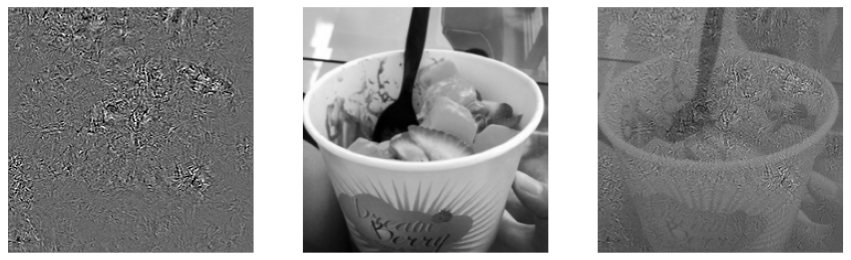

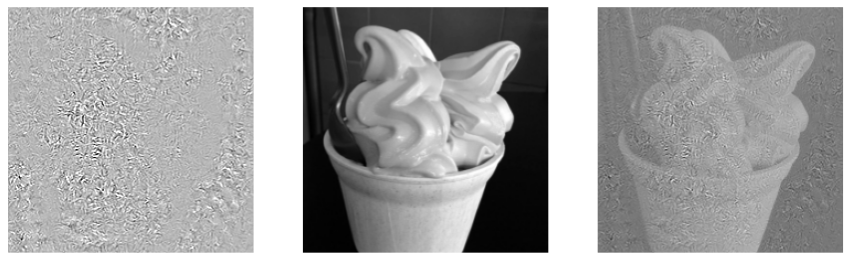

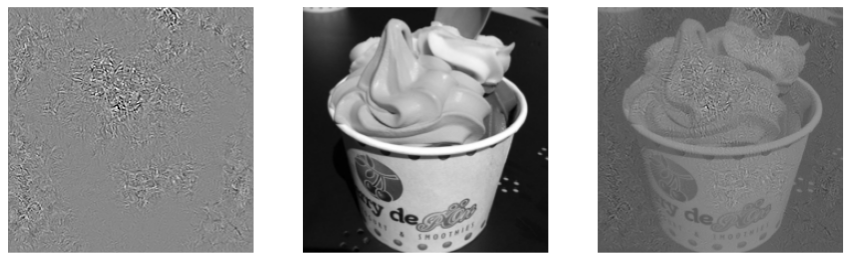

In [26]:
#filter10
for i in range(3):
    img, grad = get_im_grad(net2, 10, i)
    plot_maps(norm_flat_image(grad.unsqueeze(0)), norm_flat_image(img.unsqueeze(0)))

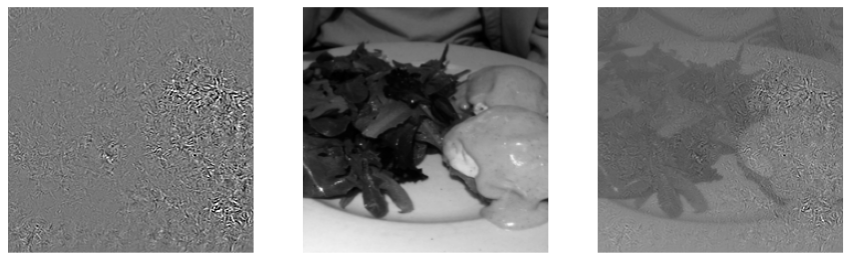

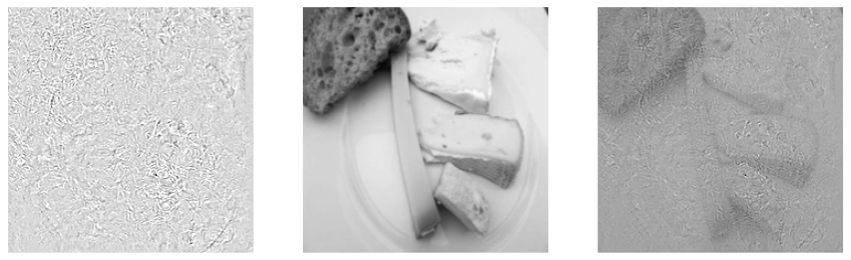

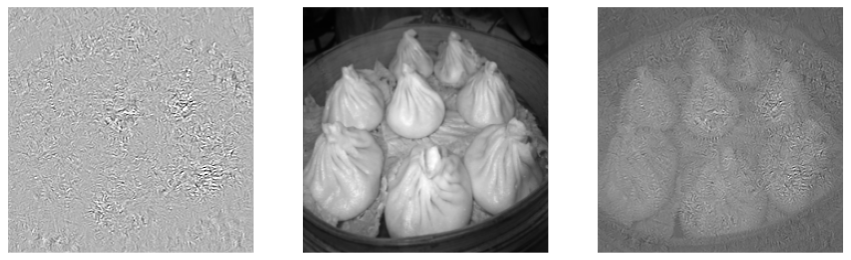

In [27]:
#filter50
for i in range(3):
    img, grad = get_im_grad(net2, 50, i)
    plot_maps(norm_flat_image(grad.unsqueeze(0)), norm_flat_image(img.unsqueeze(0)))

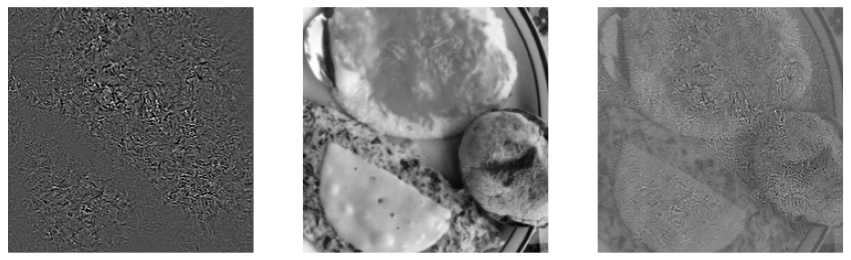

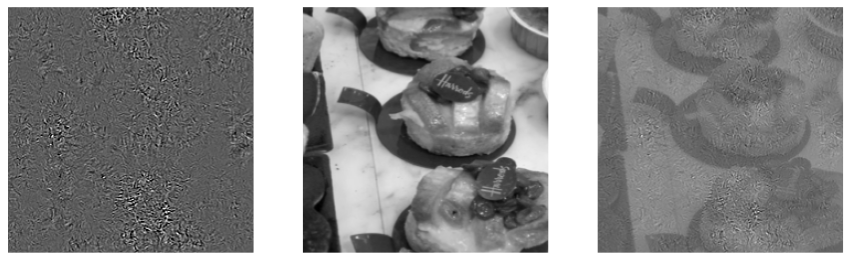

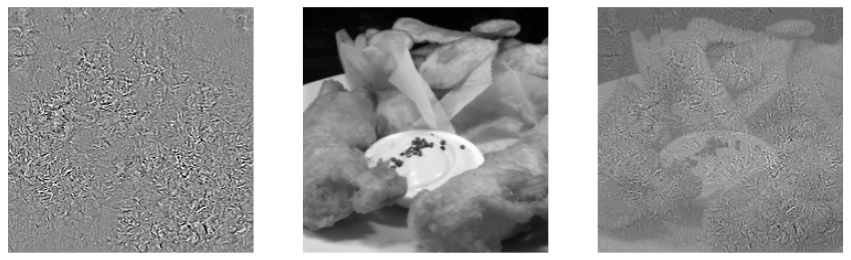

In [28]:
#filter100
for i in range(3):
    img, grad = get_im_grad(net2, 100, i)
    plot_maps(norm_flat_image(grad.unsqueeze(0)), norm_flat_image(img.unsqueeze(0)))

Вывод: в данном отчете была подтверждена гипотеза о локализации изображений с проходом вперед по сети, был проведен отбор изображений, на которых достигается максимум после активации с последующей их визуализацией. Также были проведены эксперименты с аугментациями изображений.